Goal: Give your agent up‑to‑date, domain‑specific knowledge so it can answer beyond the LLM’s training data.

We’ll layer retrieval, routing, and an optional web‑search fallback on top of the tool‑enabled agent from Step 5.

In [ ]:
!pip install langchain_community langchain_openai pathlib chromadb docx2txt langchain_tavily langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 10.7 MB/s eta 0:00:00


In [68]:
# Index your documents once
# ── Build & persist a Chroma index ────────────────────────────────
from pathlib import Path
from langchain_community.document_loaders import PyPDFLoader, TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI
from google.colab import userdata

openai_api_key = userdata.get('OPENAI_API_KEY')

# Initialize the LLM
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0.7, api_key=openai_api_key)

SOURCE_DIR   = Path("docs")          # put your files here
INDEX_DIR    = Path("chroma_db_1")   # will be created if missing
EMBED_MODEL  = "text-embedding-3-small"

# Load docs (keep only pdf/txt for brevity)
docs = []
for f in SOURCE_DIR.glob("*.*"):
    if f.suffix == ".pdf":
        try:
            docs += PyPDFLoader(str(f)).load()
        except Exception as e:
            print(f"Error loading PDF file {f}: {e}")
    elif f.suffix == ".txt":
        try:
            docs += TextLoader(str(f)).load()
        except Exception as e:
            print(f"Error loading TXT file {f}: {e}")

print(f"Loaded {len(docs)} documents from the folder.")


Loaded 4 documents from the folder.


In [71]:
docs[2]

Document(metadata={'source': 'docs/www.galileo.ai_blog_mastering-agents-evaluating-ai-agents.txt'}, page_content='Source: https://www.galileo.ai/blog/mastering-agents-evaluating-ai-agents\n\nPlatform\nDocs\nPricing\nBlog\nAbout\nLogin\nContact Sales\nSign Up\nDec 18, 2024\nPratik Bhavsar\nGalileo Labs\nPratik Bhavsar\nGalileo Labs\nImagine you\'re working with an AI assistant that claims it can help you complete your tasks. Can you trust it to analyze data effectively? To write important press releases? To make complex product decisions?\nEvaluating AI agents isn\'t like testing traditional software where you can check if the output matches expected results. These agents perform complex tasks that often have multiple valid approaches. They need to understand context and follow specific rules while sometimes persuading or negotiating with humans. This creates unique challenges for researchers and developers trying to ensure these systems are both capable and reliable.\nIn this post we\'

In [72]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    length_function=len
)
# Split & embed
chunks = text_splitter.split_documents(docs)
print(f"Split the documents into {len(chunks)} chunks.")

Split the documents into 154 chunks.


In [74]:
from google.colab import userdata
openai_api_key = userdata.get('OPENAI_API_KEY')
embeddings = OpenAIEmbeddings(model=EMBED_MODEL,api_key=openai_api_key)
vectordb = Chroma.from_documents(
    documents         = chunks,
    embedding         = embeddings,
    persist_directory = str(INDEX_DIR),
    collection_name   = "kb_collection",
)
vectordb.persist()
print("✅ Index built →", INDEX_DIR.resolve())

✅ Index built → /content/chroma_db_1


In [75]:
retriever = vectordb.as_retriever(search_kwargs={"k": 2})
retriever_results = retriever.invoke("how external memory systems can help agents")
retriever_results

[Document(metadata={'source': 'docs/www.galileo.ai_blog_mastering-agents-evaluating-ai-agents.txt'}, page_content="Tool Integration Assessment: Evaluation of how agents use self-reflection when working with external tools like code interpreters or search engines.\nMemory System Integration: Investigation of how external memory systems can help agents store and retrieve self-reflections for similar but not identical problems.\nThe ability to effectively evaluate an agent's self-reflection will play a key role in understanding and design systems which can accomplish next generation tasks while make and correcting mistakes.\nWe build agents to accomplish goals. As AI systems become more sophisticated in their interactions with humans, understanding and evaluating their capacity for persuasion and potential manipulation has become a must to increase their effectiveness while keeping them safe. Three interesting tasks help us assess these capabilities, each focusing on different aspects of 

In [76]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["LANGCHAIN_PROJECT"] = "langgraph-rag"

In [77]:
#Expose a Retriever as a LangChain Tool
from langchain_core.tools import tool
retriever = vectordb.as_retriever(search_kwargs={"k": 2})

@tool
def rag_search_tool(query: str) -> str:
    """Top-3 chunks from KB (empty string if none)"""
    try:
        docs = retriever.invoke(query, k=3)
        return "\n\n".join(d.page_content for d in docs) if docs else ""
    except Exception as e:
        return f"RAG_ERROR::{e}"


In [78]:
# Optional fallback → real‑time web search
from langchain_tavily import TavilySearch
from google.colab import userdata

tavily_api_key = userdata.get('TAVILY_API_KEY')

tavily = TavilySearch(max_results=3, topic="general", tavily_api_key=tavily_api_key)

@tool
def web_search_tool(query: str) -> str:
    """Up-to-date web info via Tavily"""
    try:
        result = tavily.invoke({"query": query})

        # Extract and format the results from Tavily response
        if isinstance(result, dict) and 'results' in result:
            formatted_results = []
            for item in result['results']:
                title = item.get('title', 'No title')
                content = item.get('content', 'No content')
                url = item.get('url', '')
                formatted_results.append(f"Title: {title}\nContent: {content}\nURL: {url}")

            return "\n\n".join(formatted_results) if formatted_results else "No results found"
        else:
            return str(result)
    except Exception as e:
        return f"WEB_ERROR::{e}"

In [79]:
web_search_tool.invoke("how external memory systems can help agents")

"Title: The Role of Memory in LLMs and AI Agents\nContent: Image 2 Image 3: Prasad’s Substack Prasad’s Substack The Role of Memory in LLMs and AI Agents Image 6 Image 7: Prasad’s Substack Prasad’s Substack The Role of Memory in LLMs and AI Agents Like LLMs, AI agents use working memory to hold information relevant to their current task. AI agents often use semantic memory to store general knowledge about the world. While LLMs rely heavily on short-term, semantic, and external memory systems, AI agents utilize a broader range of memory types to interact dynamically with their environment. Tools like vector databases, embeddings, and RAG enable the implementation of these memory types, enhancing the capabilities of both LLMs and AI agents. Image 11 Image 12: Prasad’s Substack Prasad’s Substack The Role of Memory in LLMs and AI Agents\nURL: https://prasadnell.substack.com/p/the-role-of-memory-in-llms-and-ai\n\nTitle: Memory in Agents: What, Why and How - mem0.ai\nContent: Memory in Agents

In [80]:
rag_search_tool.invoke("how external memory systems can help agents")

"Tool Integration Assessment: Evaluation of how agents use self-reflection when working with external tools like code interpreters or search engines.\nMemory System Integration: Investigation of how external memory systems can help agents store and retrieve self-reflections for similar but not identical problems.\nThe ability to effectively evaluate an agent's self-reflection will play a key role in understanding and design systems which can accomplish next generation tasks while make and correcting mistakes.\nWe build agents to accomplish goals. As AI systems become more sophisticated in their interactions with humans, understanding and evaluating their capacity for persuasion and potential manipulation has become a must to increase their effectiveness while keeping them safe. Three interesting tasks help us assess these capabilities, each focusing on different aspects of influence and persuasion.\nNatural Persuasion in Open Discussions\n\nTool Integration Assessment: Evaluation of ho

In [81]:
# ── Pydantic schemas ─────────────────────────────────────────────────
class RouteDecision(BaseModel):
    route: Literal["rag", "answer", "end"]
    reply: str | None = Field(None, description="Filled only when route == 'end'")

class RagJudge(BaseModel):
    sufficient: bool


In [82]:
# ── LLM instances with structured output where needed ───────────────
from google.colab import userdata
openai_api_key = userdata.get('OPENAI_API_KEY')
router_llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0,api_key=openai_api_key)\
             .with_structured_output(RouteDecision)
judge_llm  = ChatOpenAI(model="gpt-4.1-mini", temperature=0,api_key=openai_api_key)\
             .with_structured_output(RagJudge)
answer_llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0.7,api_key=openai_api_key)

In [83]:
# ── Shared state type ────────────────────────────────────────────────
from typing import Annotated, TypedDict
from typing   import List
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages
class AgentState(TypedDict, total=False):
    messages: List[BaseMessage]
    route:    Literal["rag", "answer", "end"]
    rag:      str
    web:      str


In [84]:
# ── Node 1: decision/router ─────────────────────────────────────────
def router_node(state: AgentState) -> AgentState:
    query = next((m.content for m in reversed(state["messages"])
                  if isinstance(m, HumanMessage)), "")

    # Use structured output properly - pass messages directly
    messages = [
        ("system", (
            "You are a router that decides how to handle user queries:\n"
            "- Use 'end' for pure greetings/small-talk (also provide a 'reply')\n"
            "- Use 'rag' when knowledge base lookup is needed\n"
            "- Use 'answer' when you can answer directly without external info"
        )),
        ("user", query)
    ]

    result: RouteDecision = router_llm.invoke(messages)

    out = {"messages": state["messages"], "route": result.route}
    if result.route == "end":
        out["messages"] = state["messages"] + [AIMessage(content=result.reply or "Hello!")]
    return out

In [85]:
# ── Node 2: RAG lookup ───────────────────────────────────────────────
def rag_node(state: AgentState) -> AgentState:
    query = next((m.content for m in reversed(state["messages"])
                  if isinstance(m, HumanMessage)), "")

    chunks = rag_search_tool.invoke({"query": query})

    # Use structured output to judge if RAG results are sufficient
    judge_messages = [
        ("system", (
            "You are a judge evaluating if the retrieved information is sufficient "
            "to answer the user's question. Consider both relevance and completeness."
        )),
        ("user", f"Question: {query}\n\nRetrieved info: {chunks}\n\nIs this sufficient to answer the question?")
    ]

    verdict: RagJudge = judge_llm.invoke(judge_messages)

    return {
        **state,
        "rag": chunks,
        "route": "answer" if verdict.sufficient else "web"
    }

# ── Node 3: web search ───────────────────────────────────────────────
def web_node(state: AgentState) -> AgentState:
    query = next((m.content for m in reversed(state["messages"])
                  if isinstance(m, HumanMessage)), "")
    snippets = web_search_tool.invoke({"query": query})
    return {**state, "web": snippets, "route": "answer"}


In [86]:

# ── Node 4: final answer ─────────────────────────────────────────────
def answer_node(state: AgentState) -> AgentState:
    user_q = next((m.content for m in reversed(state["messages"])
                   if isinstance(m, HumanMessage)), "")

    ctx_parts = []
    if state.get("rag"):
        ctx_parts.append("Knowledge Base Information:\n" + state["rag"])
    if state.get("web"):
        ctx_parts.append("Web Search Results:\n" + state["web"])

    context = "\n\n".join(ctx_parts) if ctx_parts else "No external context available."

    prompt = f"""Please answer the user's question using the provided context.

Question: {user_q}

Context:
{context}

Provide a helpful, accurate, and concise response based on the available information."""

    ans = answer_llm.invoke([HumanMessage(content=prompt)]).content

    return {
        **state,
        "messages": state["messages"] + [AIMessage(content=ans)]
    }


In [87]:

# ── Routing helpers ─────────────────────────────────────────────────
def from_router(st: AgentState) -> Literal["rag", "answer", "end"]:
    return st["route"]

def after_rag(st: AgentState) -> Literal["answer", "web"]:
    return st["route"]

def after_web(_) -> Literal["answer"]:
    return "answer"


In [88]:
# ── Build graph ─────────────────────────────────────────────────────
g = StateGraph(AgentState)
g.add_node("router", router_node)
g.add_node("rag_lookup", rag_node)
g.add_node("web_search", web_node)
g.add_node("answer", answer_node)

g.set_entry_point("router")
g.add_conditional_edges("router", from_router,
                        {"rag": "rag_lookup", "answer": "answer", "end": END})
g.add_conditional_edges("rag_lookup", after_rag,
                        {"answer": "answer", "web": "web_search"})
g.add_edge("web_search",  "answer")
g.add_edge("answer", END)

agent = g.compile(checkpointer=MemorySaver())



In [89]:

# ── Quick CLI test ───────────────────────────────────────────────────
if __name__ == "__main__":
    config = {"configurable": {"thread_id": "thread-12"}}
    print("RAG Agent CLI (type 'quit' or 'exit' to stop)")
    print("-" * 50)

    while True:
        q = input("\nYou: ").strip()
        if q.lower() in {"quit", "exit"}:
            break

        try:
            result = agent.invoke(
                {"messages": [HumanMessage(content=q)]},
                config=config
            )

            # Get the last AI message
            last_message = next((m for m in reversed(result["messages"])
                               if isinstance(m, AIMessage)), None)

            if last_message:
                print(f"Agent: {last_message.content}")
            else:
                print("Agent: No response generated")

        except Exception as e:
            print(f"Error: {e}")

    print("\nGoodbye!")

RAG Agent CLI (type 'quit' or 'exit' to stop)
--------------------------------------------------

You: how external memory systems can help agents
Agent: External memory systems can help agents by enabling them to store and retrieve information beyond their immediate working memory. This allows agents to handle more complex tasks, remember past experiences, improve decision-making, and adapt to new situations more effectively.

You: Who is Shub
Agent: There is no information available about Shub in the provided context. Could you please provide more details or specify who you are referring to?


KeyboardInterrupt: Interrupted by user

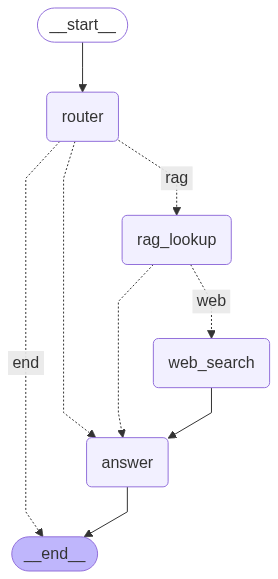

In [91]:
img = agent.get_graph(xray=True).draw_mermaid_png()
with open("graph.png", "wb") as f:
    f.write(img)
from IPython.display import(Image, display)
display(Image("graph.png"))